In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from keras.models import Model
%matplotlib inline

In [2]:
from urllib.request import urlretrieve
import zipfile

In [3]:
# Загрузим MovieLens данные. Миллионы данных слишком много для моей машины, поэтому я возьму датасет поменьше
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
# Сдвинем индексы
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [4]:
# Создадим общий датафрейм
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [5]:
# Поделим выборку на тестовую и тренировочную
# 
# Валидационная выборка в моем случаем сопадает с тестовой, т.к. я не планирую перебирать гиперпараметры и буду тренировать
# модель лишь на 4 эпохах
# 
# В общем случае стоило бы сделать 2-ве дополнительных выборки,
# одну для подбора гиперпараметров, а вторую для теста модели уже в конце
train, test = train_test_split(movielens, test_size=0.1)

In [6]:
# Получим константы для компиляции модели, чем больше EMBEDDING_SIZE, тем лучше будет метрика модели,
# на примере я буду обучать при EMBEDDING_SIZE = 10, в общем случае надо брать больше
ROW_COUNT = train.shape[0]
EMBEDDING_SIZE = 10
NUM_USERS = movielens['user_id'].nunique()
NUM_MOVIES = movielens['movie_id'].nunique()
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

In [17]:
# Я определяю четырехслойную глубокую нейронную сеть. 
# Внутри модели есть две подмодели — movie_model и user_model
# Я определил модель именно так, чтобы после обучения модели мы могли извлечь эмбеддинги
# После каждого полносвязного слоя применяется функция активации ReLU
# Также в модель были введены Дропауты для уменьшения дисперсии модели
# Метрику буду использовать стандартную для задач регрессии - MSE
def MyRecModel(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,))

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT)(movie_input)
    movie_vec = layers.Flatten()(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,))

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT)(user_input)
    user_vec = layers.Flatten()(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(normalize=True, axes=2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(80, name='FC-1', activation='relu')(merged)
    dropout_1 = layers.Dropout(0.2, name='Dropout-1')(dense_1)

    dense_2 = layers.Dense(80, name='FC-2', activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.2, name='Dropout-2')(dense_2)

    dense_3 = keras.layers.Dense(80, name='FC-3', activation='relu')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2, name='Dropout-3')(dense_3)

    dense_4 = keras.layers.Dense(80, name='FC-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='output') (dense_4)

    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [18]:
# Скомпилируем модель
model, movie_model, user_model = MyRecModel(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

In [19]:
# Для примера я обучаю модель на 4 эпохах, в общем случае надо больше, хотя бы 100
history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                    epochs=4, validation_data = ([test.movie_id, test.user_id],test.rating), 
                    verbose=1)

Epoch 1/4
900/900 [==============================] - 6s 6ms/step - loss: 1.4133 - val_loss: 0.9250
Epoch 2/4
900/900 [==============================] - 5s 6ms/step - loss: 0.9616 - val_loss: 0.9271
Epoch 3/4
900/900 [==============================] - 5s 6ms/step - loss: 0.9509 - val_loss: 0.9363
Epoch 4/4
900/900 [==============================] - 5s 6ms/step - loss: 0.9387 - val_loss: 0.9200


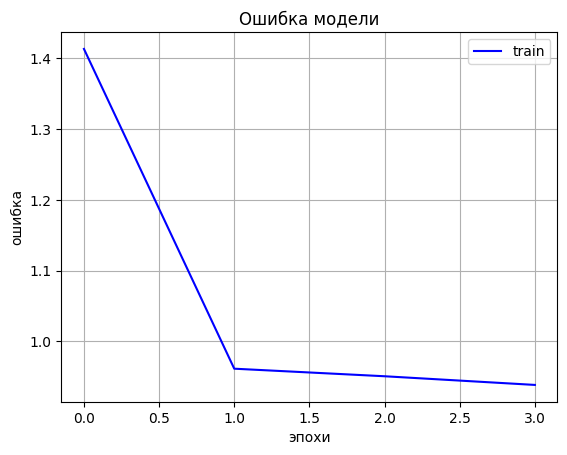

In [20]:
# Построим кривую лосса
from pylab import rcParams
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'b')
plt.title('Ошибка модели')
plt.ylabel('ошибка')
plt.xlabel('эпохи')
plt.legend(['train'], loc='best')
plt.grid(True)
plt.show()

In [21]:
# Получим эмбеддинги фильмов и пользователей из модели
movie_embeddings = movie_model.predict(UNIQUE_MOVIE_IDS)
user_embeddings = user_model.predict(np.unique(train.user_id))

30/30 [==============================] - 0s 900us/step


In [22]:
movie_embeddings.shape

(1682, 10)

In [23]:
# Эмбеддинги фильмов
movie_embeddings

array([[-0.01463892,  0.02268028,  0.00929056, ..., -0.01068565,
         0.02888579,  0.05290078],
       [-0.03621806,  0.04523977, -0.04229438, ..., -0.00022798,
        -0.02049305,  0.00279207],
       [ 0.02177432, -0.02757544, -0.01628623, ..., -0.05131747,
         0.01186923, -0.00730504],
       ...,
       [-0.01945971, -0.02466303, -0.03598614, ..., -0.01569827,
        -0.00358397, -0.04452492],
       [-0.01021344, -0.04905437,  0.0014668 , ...,  0.02622364,
         0.00773439,  0.02139423],
       [ 0.04202262, -0.02898257, -0.01536005, ...,  0.00222034,
         0.04384011, -0.00655439]], dtype=float32)

In [24]:
user_embeddings.shape

(943, 10)

In [25]:
# Эмбеддинги пользователей
user_embeddings

array([[ 4.04761881e-02, -3.77729274e-02,  4.23338352e-04, ...,
         3.20076421e-02, -3.78226750e-02, -6.30280841e-03],
       [-1.07144285e-03, -4.78504517e-04,  1.02972996e-03, ...,
        -5.16932011e-02,  1.51262656e-02,  5.02096526e-02],
       [ 7.55974761e-05, -1.87876187e-02, -4.24352325e-02, ...,
         3.49533148e-02, -6.89095166e-03,  5.57508022e-02],
       ...,
       [-2.78810114e-02, -2.23194226e-03,  2.37095356e-02, ...,
         3.88851063e-03,  3.58915925e-02, -1.47054745e-02],
       [ 2.98926197e-02,  3.25475074e-02,  3.89462081e-03, ...,
        -3.34096365e-02,  2.45810058e-02, -6.27305824e-03],
       [-3.52778360e-02,  2.21713129e-02, -3.74471135e-02, ...,
        -4.24650358e-03,  2.61892825e-02,  3.95341963e-02]], dtype=float32)

In [26]:
# Далее можно использовать KNN и рекомендовать пользователям фильмы